# Part 4 !! Pandas DataFrame to PostgreSQL using Python

## Comparison of Methods for Importing bulk CSV data Into PostgreSQL Using Python
<i>Author: Mohammad Shahid<br>
<i>[Medium Profile](https://medium.com/analytics-vidhya/part-3-7-pandas-dataframe-to-postgresql-using-python-6590fda63f41)

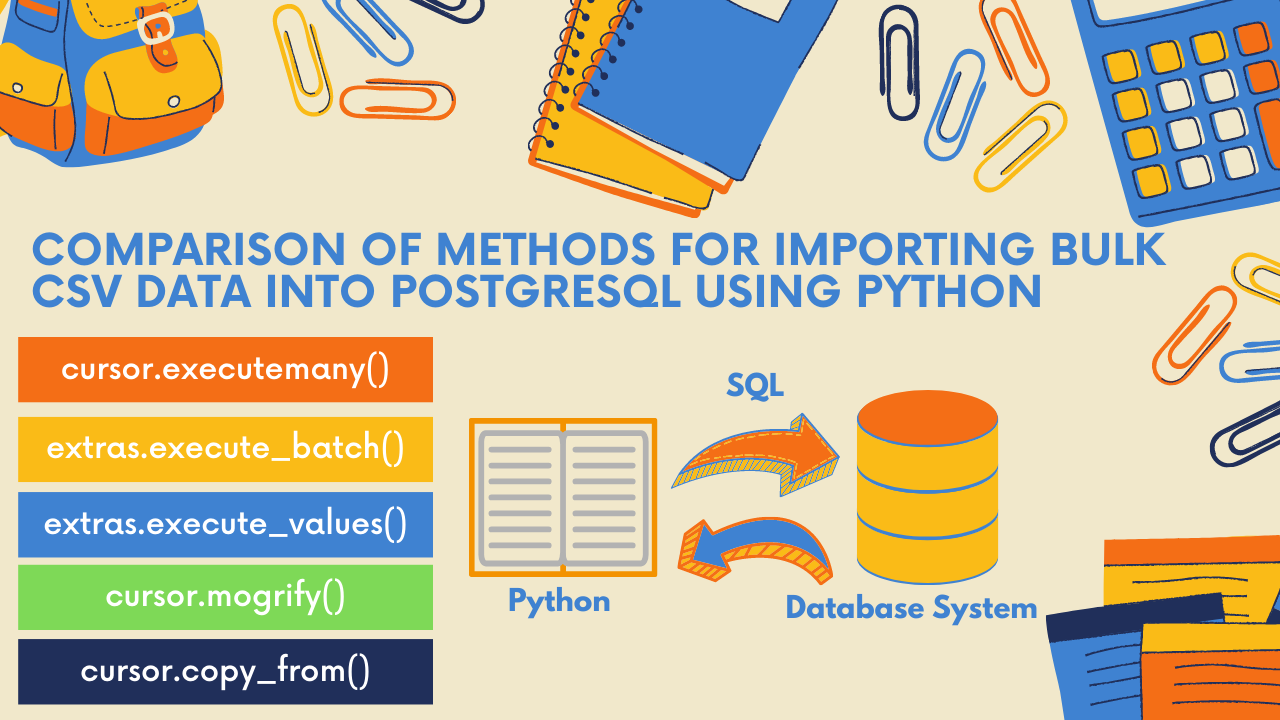

## Table of Contents
1. [**Overview**](#Overview)
2. [**Prerequisites**](#Prerequisites)
3. [**Prepare or Identify Your Data**](#Identify_Data)<br>
3.1 [Import libraries](#Import_libraries)<br>
3.2 [Extract the Data](#Extract_the_Data)<br>
3.3 [Create a Table in PostgreSQL Database](#Create_Table)<br>
4. [**Measuring Time**](#Running_Time)<br>
5. [**Method**](#Methods)<br>
5.1 [Using single one by one insert](#Using_single_insertion)<br>
5.2 [Using execute_many()](#Using_execute_many())<br>
5.3 [Using execute_batch()](#Using_execute_batch())<br>
5.4 [Using execute_values()](#Using_execute_values())<br>
5.5 [Using execute_mogrify()](#Using_execute_mogrify())<br>
5.6 [Using copy_from()](#Using_copy_from())<br>
5.7 [Using Using copy_from() a String Iterator with Buffer Size](#Using_copy_from()_with_StringIO)<br>
5.8 [Using to_sql()](#Using_to_sql())<br> 
6. [**Results**](#Results)
7. [**Conclusion**](#Conclusion)


<a class="anchor" id="Overview"></a>
## 1. Overview
The main objective of this tutorial is to find the best method to import bulk CSV data into PostgreSQL.

<a class="anchor" id="Prerequisites"></a>
## 2. Prerequisites
Python 3.8.3 : [Anaconda download link](https://www.anaconda.com/products/individual)<br>
PostgreSQL 13 : [Download link](#https://www.postgresql.org/download/)<br>
Psycopg2 : To install Psycopg2 use the command: pip install psycopg2

<a class="anchor" id="Identify_Data"></a>
## 3. Prepare or Identify Your Data

To begin, prepare or identify the CSV file that you’d like to import to PostgreSQL database. For example, we loaded iris data from GitHub.

<a class="anchor" id="Import_libraries"></a>
### 3.1 Import Libraries

In [126]:
import os
# import sys to get more detailed Python exception info
import sys
# import the connect library for psycopg2
import psycopg2
# import the error handling libraries for psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import psycopg2.extras as extras
import pandas as pd
from io import StringIO
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

<a class="anchor" id="Extract_the_Data"></a>
### 3.2 Extract the Data

In [13]:
# Loading data from github
irisData = pd.read_csv('https://raw.githubusercontent.com/Muhd-Shahid/Learn-Python-Data-Access/main/iris.csv',index_col=False)
irisData.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<a class="anchor" id="Create_Table"></a>
### 3.3 Create a Table in PostgreSQL Database

To connect from Python to a PostgreSQL database, we use psycopg:

##### Specify the connection parameters

In [14]:
# Note: please change your database, username & password as per your own values
conn_params_dic = {
    "host"      : "localhost",
    "database"  : "irisdb",
    "user"      : "postgres",
    "password"  : "Passw0rd"
}

##### Define function to establish connection

In [15]:
# Define a connect function for PostgreSQL database server
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL...........')
        conn = psycopg2.connect(**conn_params_dic)
        print("Connection successfully..................")
        
    except OperationalError as err:
        # passing exception to function
        show_psycopg2_exception(err)        
        # set the connection to 'None' in case of error
        conn = None
    return conn

##### Define function to catch exception

In [16]:
# Define a function that handles and parses psycopg2 exceptions
def show_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()    
    # get the line number when exception occured
    line_n = traceback.tb_lineno    
    # print the connect() error
    print ("\npsycopg2 ERROR:", err, "on line number:", line_n)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type) 
    # psycopg2 extensions.Diagnostics object attribute
    print ("\nextensions.Diagnostics:", err.diag)    
    # print the pgcode and pgerror exceptions
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")

##### Define function to create table

In [17]:
def create_table(cursor):
    try:
        # Dropping table iris if exists
        cursor.execute("DROP TABLE IF EXISTS iris;")
        sql = '''CREATE TABLE iris(
        sepal_length DECIMAL(2,1) NOT NULL, 
        sepal_width DECIMAL(2,1) NOT NULL, 
        petal_length DECIMAL(2,1) NOT NULL, 
        petal_width DECIMAL(2,1),
        species CHAR(11)NOT NULL
        )'''
        # Creating a table
        cursor.execute(sql);
        print("iris table is created successfully................")  
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)
        # set the connection to 'None' in case of error
        conn = None

<a class="anchor" id="Running_Time"></a>
## 4. Running Time

For measuring execution time of each method, we used timeit.

In [18]:
# Example
def run_method(n):
    for i in range(n):
        3 ** n

In [19]:
from timeit import default_timer as timer
start_time = timer()
run_method(10000)
end_time = timer()
elapsed = end_time-start_time
print('function took {:.3f} ms'.format((elapsed)*1000.0))

function took 754.711 ms


<a class="anchor" id="Methods"></a>
## 5. Methods

<a class="anchor" id="Using_single_insertion"></a>
### 5.1. Using one by one inserts

To establish a baseline we start with the easiest methodology, insert records one by one:

In [131]:
def single_inserts(conn, df, table):
    for i in df.index:
        cols  = ','.join(list(df.columns))
        vals  = [df.at[i,col] for col in list(df.columns)]
        query = "INSERT INTO %s(%s) VALUES(%s,%s,%s,%s,'%s')" % (table, cols, vals[0], vals[1], vals[2],vals[3],vals[4])
        cursor.execute(query)
    print("single_inserts() done")

<a class="anchor" id="Using_execute_many()"></a>
### 5.2. Using execute_many()

The psycopg documentation : using [executemany](https://www.psycopg.org/docs/cursor.html#cursor.executemany) 

<blockquote>Execute a database operation (query or command) against all parameter tuples or mappings found in the sequence vars_list.</blockquote>

In [21]:
# Define function using cursor.executemany() to insert the dataframe
def execute_many(conn, datafrm, table):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(sql, tpls)
        # conn.commit()
        print("Data inserted using execute_many() successfully...")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_execute_batch()"></a>
### 5.3. Using execute_batch()


The psycopg documentation : ["fast execution helpers" section:](https://www.psycopg.org/docs/extras.html#fast-execution-helpers)

<blockquote>The current implementation of executemany() is (using an extremely charitable understatement) not particularly performing. These functions can be used to speed up the repeated execution of a statement against a set of parameters. By reducing the number of server roundtrips the performance can be orders of magnitude better than using executemany().</blockquote>

The psycopg documentation : ["executemany" section:](https://www.psycopg.org/docs/extras.html#psycopg2.extras.execute_batch)
<blockquote>Execute groups of statements in fewer server roundtrips.</blockquote>

In [22]:
# Define function using psycopg2.extras.execute_batch() to insert the dataframe
def execute_batch(conn, datafrm, table, page_size=150):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_batch(cursor, sql, tpls, page_size)
        #conn.commit()
        print("Data inserted using execute_batch() successfully...")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_execute_values()"></a>
### 5.4. Using execute_values()

The psycopg documentation : ["execute_values"](https://www.psycopg.org/docs/extras.html#psycopg2.extras.execute_values) section:

<blockquote>Execute a statement using VALUES with a sequence of parameters.</blockquote>

In [23]:
# Define function using psycopg2.extras.execute_values() to insert the dataframe.
def execute_values(conn, datafrm, table):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, sql, tpls)
        #conn.commit()
        print("Data inserted using execute_values() successfully..")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_execute_mogrify()"></a>
### 5.5. Using execute_mogrify()

<blockquote>Return a query string after arguments binding. The string returned is exactly the one that would be sent to the database running the execute() method or similar.</blockquote>

In [24]:
# Define function using execute.mogrify() to insert the dataframe.
def execute_mogrify(conn, datafrm, table):
   
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL quert to execute
    cursor = conn.cursor()
    values = [cursor.mogrify("(%s,%s,%s,%s,%s)", tup).decode('utf8') for tup in tpls]
    sql  = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)
    try:
        cursor.execute(sql, tpls)
        #conn.commit()
        print("Data inserted using execute_mogrify() successfully.")
        cursor.close()
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_copy_from()"></a>
### 5.6. Using Using copy_from()

The psycopg documentation : ["copy_from()"](https://www.psycopg.org/docs/cursor.html#cursor.copy_from) section:

<blockquote>To use copy from Python, psycopg provides a special function called copy_from. The copy command requires a CSV file. Let's see if we can transform our data into CSV, and load it into the database using copy_from:</blockquote>

In [67]:
# Define function using copy_from_dataFile to insert the dataframe.
def copy_from_dataFile(conn, df, table):
    
#  Here we are going save the dataframe on disk as a csv file, load # the csv file and use copy_from() to copy it to the table
    tmp_df = './Learn Python Data Access/iris_temp.csv'
    df.to_csv(tmp_df, header=False,index = False)
    f = open(tmp_df, 'r')
    cursor = conn.cursor()
    try:
        cursor.copy_from(f, table, sep=",")
        print("Data inserted using copy_from_datafile() successfully....")
    except (Exception, psycopg2.DatabaseError) as err:
        os.remove(tmp_df)
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_copy_from()_with_StringIO"></a>
### 5.7. Using copy_from() with StringIO

In [26]:
# Define function using copy_from() with StringIO to insert the dataframe
def copy_from_dataFile_StringIO(conn, datafrm, table):
    
  # save dataframe to an in memory buffer
    buffer = StringIO()
    datafrm.to_csv(buffer, header=False, index = False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        print("Data inserted using copy_from_datafile_StringIO() successfully....")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Using_to_sql()"></a>
### 5.8. Using to_sql()

In [72]:
# Using alchemy method
connect_alchemy = "postgresql+psycopg2://%s:%s@%s/%s" % (
    conn_params_dic['user'],
    conn_params_dic['password'],
    conn_params_dic['host'],
    conn_params_dic['database']
)

def using_alchemy(df):
    try:
        engine = create_engine(connect_alchemy)
        df.to_sql('irisAlchemy', con=engine, index=False, if_exists='append',chunksize = 1000)
        print("Data inserted using to_sql()(sqlalchemy) done successfully...")
    except OperationalError as err:
        # passing exception to function
        show_psycopg2_exception(err)
        cursor.close()

<a class="anchor" id="Results"></a>
### 6. Results

In [143]:
conn = connect(conn_params_dic)
# We set autocommit=True so every command we execute will produce results immediately.
conn.autocommit = True
cursor = conn.cursor()
create_table(cursor)

Connecting to the PostgreSQL...........
Connection successfully..................
iris table is created successfully................


### Define a function to compare the performance of each method

In [140]:
#-----------------------------------------
# COMPARE THE PERFORMANCE OF EACH METHOD
#-----------------------------------------
def compare_methods_to_insert_bulk_data(df):
    #execute_query(conn, "delete from iris where true;")
    # Delete records from iris table
    cursor.execute("delete from iris where true;")
    print("Data has been deleted from iris table..........")
    print("")
    
    methods = [single_inserts, execute_many, execute_batch, execute_values, execute_mogrify, 
               copy_from_dataFile, copy_from_dataFile_StringIO]
    df_performance = pd.DataFrame(index=range(len(methods)), columns=['Total_Records','Method_Name','Time ()'])

    k = 0
    for method in methods:
        start_time = timer()
        method(conn, df, 'iris')
        end_time = timer()
        
        df_performance.at[k,'Total_Records'] = len(df.index)
        df_performance.at[k,'Method_Name'] = method.__name__
        df_performance.at[k,'Time ()'] = end_time-start_time
        
        # Delete records for the previous method and prepare test for the next method
        # Delete records from iris table
        cursor.execute("delete from iris where true;")
        print("Data has been deleted from iris table........")
        print("")
        k = k + 1

    # Adding sqlalchemy's to_sql() method
    start_time = timer()
    using_alchemy(df)
    end_time = timer()
    df_performance.at[k,'Total_Records'] = len(df.index)
    df_performance.at[k,'Method_Name'] = "to_sql() | sqlalchemy"
    df_performance.at[k,'Time ()'] = end_time-start_time
    
    return df_performance

### Compare the performance of each method for 1000, 5000,10000, 50000,100000 rows.

In [29]:
df = irisData
# Repeating our dataframe 36667 times to get a large test dataframe
bulk_df = pd.concat([df]*667, ignore_index=True)
print(len(bulk_df.index))

100050


In [142]:
df_performance_list = []

for records in [1000,5000,10000,50000,100000]:
    print("records = %s" % records)
    df_cutoff = bulk_df[0:records]
    df_performance = compare_methods_to_insert_bulk_data(df_cutoff)
    df_performance_list.append(df_performance)
    

method_performances = pd.concat(df_performance_list, axis=0).reset_index()
method_performances.head()

records = 1000
Data has been deleted from iris table..........

single_inserts() done
Data has been deleted from iris table........

Data inserted using execute_many() successfully...
Data has been deleted from iris table........

Data inserted using execute_batch() successfully...
Data has been deleted from iris table........

Data inserted using execute_values() successfully..
Data has been deleted from iris table........

Data inserted using execute_mogrify() successfully.
Data has been deleted from iris table........

Data inserted using copy_from_datafile() successfully....
Data has been deleted from iris table........

Data inserted using copy_from_datafile_StringIO() successfully....
Data has been deleted from iris table........

Data inserted using to_sql()(sqlalchemy) done successfully...
records = 5000
Data has been deleted from iris table..........

single_inserts() done
Data has been deleted from iris table........

Data inserted using execute_many() successfully...
Data ha

,index,Total_Records,Method_Name,Time ()
0,0,1000,single_inserts,0.715806
1,1,1000,execute_many,0.41984
2,2,1000,execute_batch,0.0930687
3,3,1000,execute_values,0.0371583
4,4,1000,execute_mogrify,0.0259994


In [135]:
method_performances

,index,Total_Records,Method_Name,Time ()
0,0,1000,single_inserts,0.660029
1,1,1000,execute_many,0.42568
2,2,1000,execute_batch,0.0616366
3,3,1000,execute_values,0.031981
4,4,1000,execute_mogrify,0.0278973
5,5,1000,copy_from_dataFile,0.0417279
6,6,1000,copy_from_dataFile_StringIO,0.0125529
7,7,1000,to_sql() | sqlalchemy,0.288937
8,0,5000,single_inserts,2.8907
9,1,5000,execute_many,2.05569


### Visualize the performance of each method

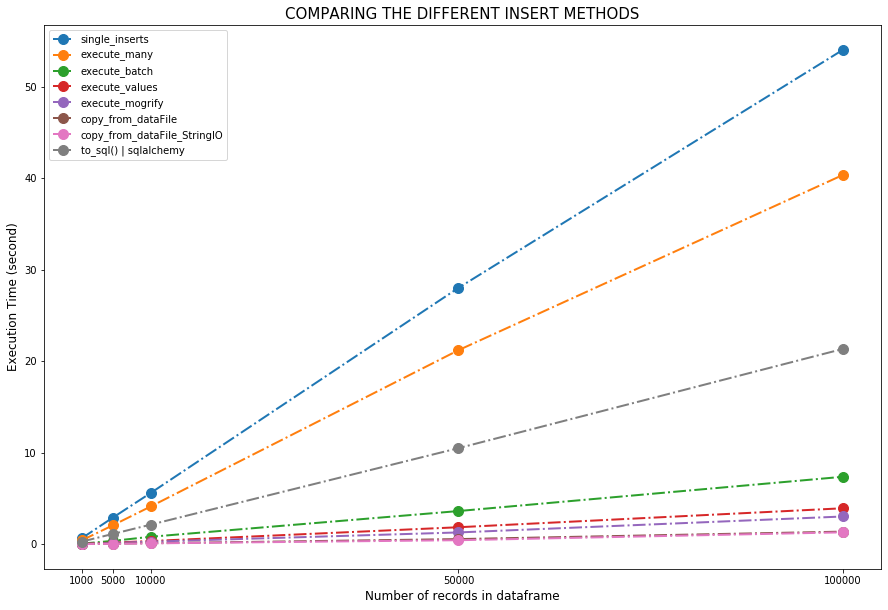

In [136]:
fig, ax = plt.subplots(figsize=(15,10))
for method in method_performances['Method_Name'].unique():
    subset = method_performances[method_performances['Method_Name'] == method]    
    ax.plot(subset['Total_Records'], subset['Time ()'], 'o-.', label=method, linewidth=2, markersize=10)

plt.xticks([1000, 5000,10000, 50000,100000])
plt.xlabel('Number of records in dataframe',fontsize=12)
plt.ylabel('Execution Time (second)',fontsize=12)
plt.title("COMPARING THE DIFFERENT INSERT METHODS", fontsize=15)
plt.legend()
plt.savefig("D:/Shahid/Analytics/Medium Tutorila/Learn Python Data Access/all_methods.png", dpi=600)
plt.show()

In [ ]:
# Closing the cursor & connection
cursor.close()
conn.close()

<a class="anchor" id="Conclusion"></a>
### 7. Conclusion

Now, the main question is what should we use? the answer is It depends.
Each method has its own advantages and disadvantages, and is suited for different circumstances.
It is evident from the graph above that the fastest method is to use copy_from however, execute_values() and execute_mogrify() are also fine methods to import the data.

### Previous Learning

### [Part 1: Introduction , Connection & Database Creation](https://medium.com/analytics-vidhya/pandas-dataframe-to-postgresql-using-python-part-1-93f928f6fac7)
### [Part 2: Create Table in PostgreSQL Database Using Python](https://medium.com/analytics-vidhya/pandas-dataframe-to-postgresql-using-python-part-2-3ddb41f473bd)
### [Part 3.1: Insert Bulk Data Using executemany() Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-1-pandas-dataframe-to-postgresql-using-python-8a3e3da87ff1)
### [Part 3.2: Insert Bulk Data Using execute_batch() Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-2-pandas-dataframe-to-postgresql-using-python-8dc0b0741226)
### [Part 3.3: Insert Bulk Data Using execute_values() method into PostgreSQL Database using Python](https://medium.com/analytics-vidhya/part-3-3-pandas-dataframe-to-postgresql-using-python-57e68fe39385)
### [Part 3.4: Insert Bulk Data Using mogrify() Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-4-pandas-dataframe-to-postgresql-using-python-d94e644a332)
### [Part 3.5: Insert Bulk Data Using copy_from() Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-5-pandas-dataframe-to-postgresql-using-python-d3bc41fcf39)
### [Part 3.6: Insert Bulk Data Using copy_from() with StringIO Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-6-pandas-dataframe-to-postgresql-using-python-ec80cb33ca4a)
### [Part 3.7: Insert Bulk Data Using to_sql()(alchemy) Into PostgreSQL Database](https://medium.com/analytics-vidhya/part-3-7-pandas-dataframe-to-postgresql-using-python-6590fda63f41)
### [Part 5.1: How to read data from PostgreSQL to Pandas DataFrame?](https://medium.com/analytics-vidhya/part-5-1-pandas-dataframe-to-postgresql-using-python-e2588e65c235)
### [Part 5.2: Extract, Transform, and Load PostgreSQL Data in Python](https://medium.com/analytics-vidhya/part-5-2-pandas-dataframe-to-postgresql-using-python-450607b763b4)

### Stay Positive !! Stay Safe !! Keep Learning :):)

<h3>Thanks you for reading!!</h3>